In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Dataset, Reader, accuracy
from surprise import SVD, KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline 
from surprise.model_selection import train_test_split
import time
import psutil
import os
import pickle

In [2]:
# Load the MovieLens dataset - https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
movies = pd.read_csv('./data/movies.csv')
ratings = pd.read_csv('./data/ratings.csv')
print(movies.head())
print(ratings.head())

   movieId                               title   
0        1                    Toy Story (1995)  \
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


### 1. Exploratory Data Analysis

In [3]:
print("MOVIES DF")# movies DF
print(movies.info())   # Check the structure of the movies DataFrame
print(movies.describe())  # Check the summary statistics of the movies
print(movies.isnull().sum())  # Check for missing values in the movies DataFrame
print("\n")

print("RATINGS DF")# ratings DF
print(ratings.info())  # Check the structure of the ratings DataFrame
print(ratings.describe()) # Check the summary statistics of the ratings
print(ratings.isnull().sum()) # Check for missing values in the ratings DataFrame


MOVIES DF
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB
None
             movieId
count    9742.000000
mean    42200.353623
std     52160.494854
min         1.000000
25%      3248.250000
50%      7300.000000
75%     76232.000000
max    193609.000000
movieId    0
title      0
genres     0
dtype: int64


RATINGS DF
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
mem

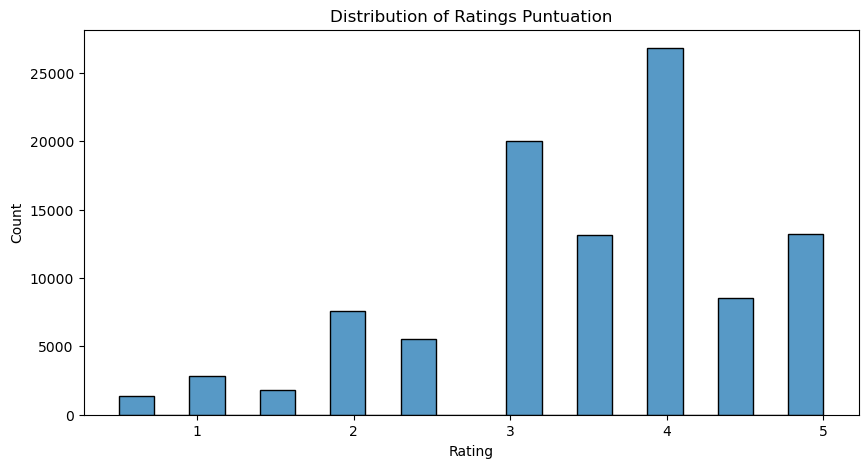

In [4]:
# Ratings distribution
plt.figure(figsize=(10,5))
sns.histplot(ratings['rating'], bins=20)
plt.title('Distribution of Ratings Puntuation')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

C:\Users\NVGG\AppData\Local\Temp\ipykernel_3096\3484477586.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=genre_df, x='Genre', y='Count', palette='viridis')


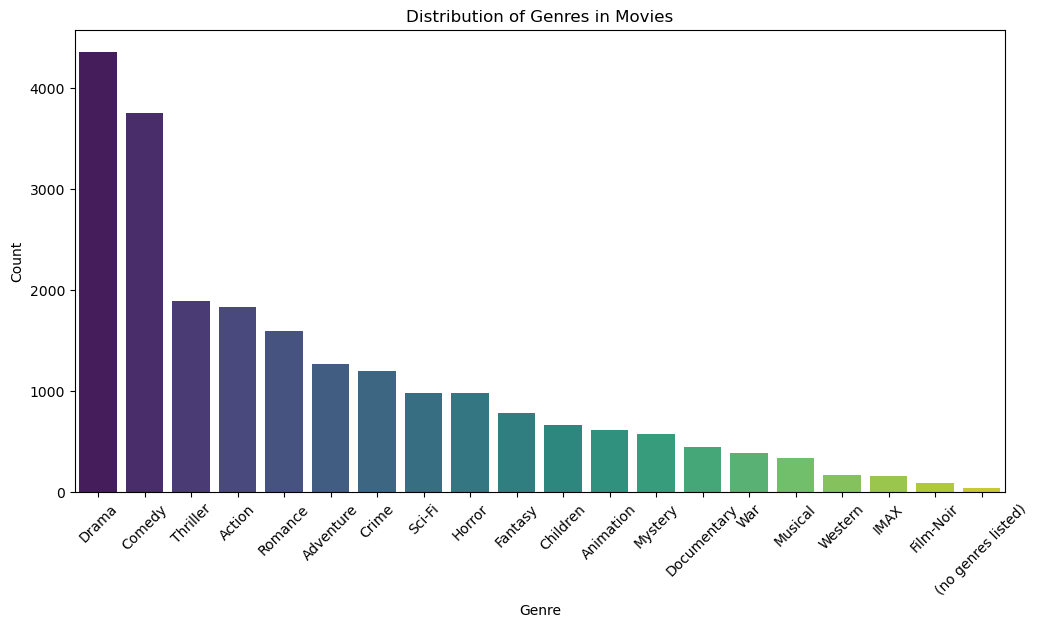

In [5]:
# Distribution of genres
from collections import Counter

# Split genres and count occurrences
genre_counts = Counter(genre for genres in movies['genres'] for genre in genres.split('|'))

# Convert to DataFrame for visualization
genre_df = pd.DataFrame(genre_counts.items(), columns=['Genre', 'Count']).sort_values(by='Count', ascending=False)

# Plot the distribution
plt.figure(figsize=(12, 6))
sns.barplot(data=genre_df, x='Genre', y='Count', palette='viridis')
plt.title('Distribution of Genres in Movies')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

### 2. Data Preprocessing

In [3]:
# Remove row with missing values
movies.dropna(inplace=True)
ratings.dropna(inplace=True)


In [4]:
# Data encoding using Surprise library
reader = Reader(rating_scale=(0.5, 5.0))  # Define the rating scale using Reader class from Surprise

# Convert the DataFrame to a Surprise dataset
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)


In [5]:
# Split dataset using train_test_split from Surprise
trainset, testset = train_test_split(data, test_size=0.2) # 80% training and 20% testing
print(type(testset))

<class 'list'>


### 3. Collaborative Filtering Model 

In [18]:
import pickle

# SVD model from Surprise library
SVD_model = SVD(random_state=42)  # Create an SVD model instance
SVD_model.fit(trainset) # Fit the model to the training set
# Save the SVD model as a pickle file
model_save_path = "D:/GitHub/DPM_IA_Mid-Term/models/SVD_model.pkl"
with open(model_save_path, "wb") as f:
    pickle.dump(SVD_model, f)

# Load the SVD model from the pickle file
with open(model_save_path, "rb") as f:
    SVD_model = pickle.load(f)

# Predictions
SVD_pred = SVD_model.test(testset) 

# Evaluate model
SVD_rmse= accuracy.rmse(SVD_pred, verbose=True)  # Calculate RMSE using the rmse function from Surprise library
print(f'RMSE: {SVD_rmse}')


RMSE: 0.8742
RMSE: 0.8741578477762303


In [19]:
# KNN model from Surprise library
sim_options = {
    "name": "cosine",
    "user_based": True,  # compute  similarities between items
    }   
KNN_model = KNNBasic(sim_options=sim_options)  # Create an KNN model instance
KNN_model.fit(trainset) # Fit the model to the training set

# Save the KNN model as a pickle file
model_save_path = "D:/GitHub/DPM_IA_Mid-Term/models/KNN_model.pkl"
with open(model_save_path, "wb") as f:
    pickle.dump(KNN_model, f)

# Load the KNN model from the pickle file
with open(model_save_path, "rb") as f:
    KNN_model = pickle.load(f)
    
# Predictions
KNN_pred = KNN_model.test(testset) 

# Evaluate model
KNN_rmse = accuracy.rmse(KNN_pred, verbose=True)  # Calculate RMSE using the rmse function from Surprise library
print(f'RMSE: {KNN_rmse}')

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9739
RMSE: 0.9739256099552799


In [29]:
# Recommendation function
def recommend_movies(user_id, model, movies, ratings, num_recommendations=10):
    # Check if the user_id exists in the ratings DataFrame
    if user_id not in ratings['userId'].unique():
        raise ValueError(f"User ID {user_id} does not exist in the ratings dataset.")
    # Filter out movies already rated by the user
    rated_movies = ratings[ratings['userId'] == user_id]['movieId']
    unique_movies = movies[~movies['movieId'].isin(rated_movies)].copy()
    # Predict ratings for the remaining movies
    unique_movies['predicted_rating'] = unique_movies['movieId'].apply(lambda x: model.predict(user_id, x).est)
    # Sort movies by predicted rating and select top N recommendations
    recommendations = unique_movies.sort_values(by='predicted_rating', ascending=False).head(num_recommendations)
    
    return recommendations[['movieId', 'title', 'predicted_rating']]


In [33]:
# Make recommendation for a specific user and movie
user_id = 1  # Example user ID

# Get recommendations for the user using the SVD model
recommendations = recommend_movies(user_id, SVD_model, movies, ratings)
print("SVD model recommendations:\n", recommendations)
print("\n")

# Get recommendations for the user using the KNN model
recommendations = recommend_movies(user_id, KNN_model, movies, ratings)
print("KNN model recommendations:\n", recommendations)


SVD model recommendations:
       movieId                                             title   
922      1221                    Godfather: Part II, The (1974)  \
951      1252                                  Chinatown (1974)   
9463   168252                                      Logan (2017)   
8376   109487                               Interstellar (2014)   
9618   177593  Three Billboards Outside Ebbing, Missouri (2017)   
824      1084                           Bonnie and Clyde (1967)   
210       246                                Hoop Dreams (1994)   
965      1266                                 Unforgiven (1992)   
961      1262                          Great Escape, The (1963)   
960      1261                Evil Dead II (Dead by Dawn) (1987)   

      predicted_rating  
922                5.0  
951                5.0  
9463               5.0  
8376               5.0  
9618               5.0  
824                5.0  
210                5.0  
965                5.0  
961      

### 4. Content-Based Filtering

In [36]:
# Content-based filtering using TF-IDF for genres
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

# TF-IDF Vectorizer for genres
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(movies['genres'].fillna(''))

# Compute similarity
CB_model = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Create a KNN model using the cosine similarity matrix
knn_model = NearestNeighbors(metric='precomputed', algorithm='brute')
knn_model.fit(CB_model)

# Save the KNN model as a pickle file
model_save_path = "D:/GitHub/DPM_IA_Mid-Term/models/CB_model.pkl"   
with open(model_save_path, "wb") as f:
    pickle.dump(knn_model, f)
# Load the KNN model from the pickle file
with open(model_save_path, "rb") as f:
    knn_model = pickle.load(f)

# # Example: Find the 10 nearest neighbors for the first movie
# distances, indices = knn_model.kneighbors(CB_model[0].reshape(1, -1), n_neighbors=10)

# # Print the nearest neighbors
# print("Nearest neighbors for the first movie:")
# for i, (index, distance) in enumerate(zip(indices[0], distances[0])):
#     print(f"{i+1}: Movie ID {movies.iloc[index]['movieId']} - Title: {movies.iloc[index]['title']} - Distance: {distance}")

In [ ]:
def recommend_movies_by_genre(genre, knn_model, movies_data, cb_model, num_recommendations=10):
    
    # Find movies that contain the specified genre
    genre_movies = movies_data[movies_data['genres'].str.contains(genre, case=False)]    
    if genre_movies.empty:
        return pd.DataFrame(columns=['movieId', 'title', 'distance'])
    
    # Get the index of the first movie with the specified genre
    movie_index = genre_movies.index[0]    
    # Find similar movies
    distances, indices = knn_model.kneighbors(cb_model[movie_index].reshape(1, -1), n_neighbors=num_recommendations+1)    
    # Create a DataFrame with recommendations
    recommendations = []
    for i, (index, distance) in enumerate(zip(indices[0], distances[0])):
        # Skip the first one if it's the same movie
        if i == 0 and index == movie_index:
            continue            
        recommendations.append({
            'movieId': movies_data.iloc[index]['movieId'],
            'title': movies_data.iloc[index]['title'],
            'distance': distance
        })        
        # Break if we have enough recommendations
        if len(recommendations) >= num_recommendations:
            break
    
    # Convert to DataFrame
    recommendations_df = pd.DataFrame(recommendations)    
    return recommendations_df

In [38]:
# Example usage
genre_to_search = "Comedy"
recommendations = recommend_movies_by_genre(
    genre=genre_to_search,
    knn_model=knn_model,
    movies_data=movies,
    cb_model=CB_model,
    num_recommendations=5
)

print(f"Top 5 movie recommendations for genre '{genre_to_search}':")
print(recommendations)

# Example with another genre
genre_to_search = "Horror"
recommendations = recommend_movies_by_genre(
    genre=genre_to_search,
    knn_model=knn_model,
    movies_data=movies,
    cb_model=CB_model,
    num_recommendations=5
)

print(f"\nTop 5 movie recommendations for genre '{genre_to_search}':")
print(recommendations)

Top 5 movie recommendations for genre 'Comedy':
   movieId                                              title  distance
0   107159  Zatoichi and the Chest of Gold (Zatôichi senry...       0.0
1     6347                                 Beat Street (1984)       0.0
2     6336     Marooned in Iraq (Gomgashtei dar Aragh) (2002)       0.0
3     6337                              Owning Mahowny (2003)       0.0
4     6334                                    Blue Car (2002)       0.0

Top 5 movie recommendations for genre 'Horror':
   movieId                                          title  distance
0    60894                       Edge of Love, The (2008)       0.0
1    60885                     Zone, The (La Zona) (2007)       0.0
2    60943                            Frozen River (2008)       0.0
3    60937  Mummy: Tomb of the Dragon Emperor, The (2008)       0.0
4    61011                             Walker, The (2007)       0.0


### 5. Hybrid filtering

In [43]:
def personalized_recommendations(user_id, genre, model, cosine_sim, movies, ratings, num_recommendations=10, weight_model=0.5, weight_similarity=0.5):
    
    # Filter movies by genre
    genre_movies = movies[movies['genres'].str.contains(genre, case=False, na=False)]

    # Exclude movies already rated by the user
    rated_movies = ratings[ratings['userId'] == user_id]['movieId']
    candidate_movies = genre_movies[~genre_movies['movieId'].isin(rated_movies)].copy()

    # Calculate predicted ratings using the recommendation model
    candidate_movies['predicted_rating'] = candidate_movies['movieId'].apply(lambda x: model.predict(user_id, x).est)

    # Calculate similarity scores
    candidate_movies['similarity_score'] = candidate_movies.index.map(
        lambda idx: cosine_sim[idx].mean() if idx < len(cosine_sim) else 0
    )

    # Calculate weighted scores
    candidate_movies['weighted_score'] = (
        weight_model * candidate_movies['predicted_rating'] +
        weight_similarity * candidate_movies['similarity_score']
    )

    # Sort by weighted score and return top recommendations
    recommendations = candidate_movies.sort_values(by='weighted_score', ascending=False).head(num_recommendations)
    return recommendations[['movieId','title', 'genres', 'weighted_score']]

In [44]:
# Make a personalized_recommendation 
user_id = 1  # Specify the user ID
genre = 'Drama'  # Specify the genre of interest
num_recommendations = 5  # Number of recommendations to return

# Get personalized recommendations
personalized_recs = personalized_recommendations(
    user_id=user_id,
    genre=genre,
    model=SVD_model,
    cosine_sim=CB_model,
    movies=movies,
    ratings=ratings,
    num_recommendations=num_recommendations
)

# Display the recommendations
print(personalized_recs)

      movieId                           title                genres   
935      1235         Harold and Maude (1971)  Comedy|Drama|Romance  \
680       898  Philadelphia Story, The (1940)  Comedy|Drama|Romance   
1798     2398   Miracle on 34th Street (1947)          Comedy|Drama   
1671     2248          Say Anything... (1989)  Comedy|Drama|Romance   
908      1207    To Kill a Mockingbird (1962)                 Drama   

      weighted_score  
935         2.662316  
680         2.657637  
1798        2.643923  
1671        2.635226  
908         2.630041  


### 6. Models Comparison


In [51]:
# 1. Accuracy prediction --> RMSE
def calculate_rmse(models, testset):
    #models (dict): A dictionary where keys are model names and values are trained model objects.
    #testset (list): A list of tuples (userId, movieId, actual_rating) from the Surprise library.    
    rmse_results = {}
    for model_name, model in models.items():
        # Generate predictions using the model
        predictions = model.test(testset)
        
        # Calculate RMSE using Surprise's accuracy module
        rmse = accuracy.rmse(predictions, verbose=False)
        rmse_results[model_name] = rmse       
    
    return rmse_results

# Evaluate models
models = {
    "SVD model": SVD_model,
    "KNN model": KNN_model
}

# Test dataset should have columns: ['userId', 'movieId', 'actual_rating']
rmse_scores = calculate_rmse(models, testset)
#print(rmse_scores)

# Print RMSE for each model
for model_name, rmse in rmse_scores.items():
    print(f"{model_name}: RMSE = {rmse:.4f}")

SVD model: RMSE = 0.8742
KNN model: RMSE = 0.9739


In [46]:
#import time
#import psutil

def calculate_training_cost(models, trainset):
    
    training_costs = {}
    
    for model_name, model in models.items():
        # Record start time and initial CPU/memory usage
        start_time = time.time()
        initial_cpu = psutil.cpu_percent(interval=None)
        #initial_memory = psutil.virtual_memory().used / (1024 ** 2)  # Convert to MB
        initial_memory = psutil.virtual_memory().percent  # Convert to MB
        
        # Train the model
        model.fit(trainset)
        
        # Record end time and final CPU/memory usage
        end_time = time.time()
        final_cpu = psutil.cpu_percent(interval=None)
        #final_memory = psutil.virtual_memory().used / (1024 ** 2)  # Convert to MB
        final_memory = psutil.virtual_memory().percent  # Convert to MB

        # Calculate metrics
        time_taken = end_time - start_time
        cpu_usage = final_cpu - initial_cpu
        memory_usage = final_memory - initial_memory
        
        # Store results
        training_costs[model_name] = {
            "time_taken": time_taken,
            "cpu_usage": cpu_usage,
            "memory_usage": memory_usage
        }
    
    return training_costs

# Example models:
models = {
    "SVD model": SVD_model,
    "KNN model": KNN_model
}

# Calculate training costs
training_costs = calculate_training_cost(models, trainset)

# Print training costs for each model
for model_name, costs in training_costs.items():
    print(f"{model_name}:")
    print(f"  Time Taken: {costs['time_taken']:.2f} seconds")
    print(f"  CPU Usage: {costs['cpu_usage']:.2f} %")
    print(f"  Memory Usage: {costs['memory_usage']:.2f} %")

Computing the cosine similarity matrix...
Done computing similarity matrix.
SVD model:
  Time Taken: 2.27 seconds
  CPU Usage: 20.00 %
  Memory Usage: -0.10 %
KNN model:
  Time Taken: 0.38 seconds
  CPU Usage: 17.20 %
  Memory Usage: -0.10 %


In [47]:
#import time

def calculate_inference_cost(models, user_ids, movies, ratings, num_recommendations=10):
    
    inference_costs = {}
    
    for model_name, model in models.items():
        # Record start time
        start_time = time.time()
        
        # Generate recommendations for the user
        #recommend_movies(user_id, model, movies, ratings, num_recommendations)
        for user_id in user_ids:
            recommend_movies(user_id, model, movies, ratings, num_recommendations)
        
        
        # Record end time
        end_time = time.time()
        
        # Calculate time taken
        time_taken = end_time - start_time
        
        # Store results
        inference_costs[model_name] = time_taken
    
    return inference_costs

# Example usage:
# Assuming you have two models (SVD_model, KNN_model) and a user ID
models = {
    "SVD model": SVD_model,
    "KNN model": KNN_model
}

# Calculate inference costs
#user_ids = [1]  # Example user ID
user_ids = [1, 2, 3, 4, 5]  # Example user IDs
num_recommendations = 10  # Number of recommendations to generate
inference_costs = calculate_inference_cost(models, user_ids, movies, ratings, num_recommendations)

# Print inference costs for each model
for model_name, time_taken in inference_costs.items():
    print(f"{model_name}: Time Taken for Inference = {time_taken:.4f} seconds")

SVD model: Time Taken for Inference = 0.8564 seconds
KNN model: Time Taken for Inference = 1.7777 seconds


In [48]:
def calculate_throughput(models, user_ids, movies, ratings, num_recommendations=10):
    
    throughput_results = {}
    
    for model_name, model in models.items():
        # Record start time
        start_time = time.time()
        
        # Generate recommendations for the user
        #recommend_movies(user_id, model, movies, ratings, num_recommendations)
        for user_id in user_ids:
            recommend_movies(user_id, model, movies, ratings, num_recommendations)
        
        # Record end time
        end_time = time.time()
        
        # Calculate time taken
        time_taken = end_time - start_time
        
        # Calculate throughput (recommendations per second)
        if time_taken > 0:
            throughput = num_recommendations / time_taken
        else:
            throughput = float('inf')  # Handle edge case where time_taken is 0
        
        # Store results
        throughput_results[model_name] = throughput
    
    return throughput_results

# Example usage:
# Assuming you have two models (SVD_model, KNN_model) and a user ID
models = {
    "SVD model": SVD_model,
    "KNN model": KNN_model
}

# Calculate throughput
#user_ids = 1  # Example user ID
user_ids = [1, 2, 3, 4, 5]  # Example user IDs
num_recommendations = 10  # Number of recommendations to generate
throughput_results = calculate_throughput(models, user_ids, movies, ratings, num_recommendations)

# Print throughput for each model
for model_name, throughput in throughput_results.items():
    print(f"{model_name}: Throughput = {throughput:.2f} recommendations/second")

SVD model: Throughput = 11.83 recommendations/second
KNN model: Throughput = 5.67 recommendations/second


In [52]:
#import os
#import psutil
#import time

def calculate_model_size_and_memory(models, user_ids, movies, ratings, num_recommendations=10, model_save_path="models/"):
    
    results = {}

    # Ensure the model save path exists
    os.makedirs(model_save_path, exist_ok=True)

    for model_name, model in models.items():
        # Save the model to disk temporarily to calculate its size
        model_file_path = os.path.join(model_save_path, f"{model_name}.pkl")
        with open(model_file_path, "wb") as f:
            import pickle
            pickle.dump(model, f)
        
        # Calculate disk size in MB
        disk_size = os.path.getsize(model_file_path) / (1024 ** 2)  # Convert bytes to MB

        # Measure memory usage during inference
        process = psutil.Process(os.getpid())  # Get the current process
        initial_memory = process.memory_info().rss / (1024 ** 2)  # Memory in MB

        # Perform inference for all users
        for user_id in user_ids:
            recommend_movies(user_id, model, movies, ratings, num_recommendations)

        final_memory = process.memory_info().rss / (1024 ** 2)  # Memory in MB
        memory_usage = final_memory - initial_memory

        # Store results
        results[model_name] = {
            "disk_size": disk_size,
            "memory_usage": memory_usage
        }

        # Clean up the saved model file
        os.remove(model_file_path)

    return results

# Example usage:
# Assuming you have two models (SVD_model, KNN_model) and a list of user IDs
models = {
    "SVD model": SVD_model,
    "KNN model": KNN_model
}

# List of user IDs for whom recommendations are generated
user_ids = [1, 2, 3, 4, 5]  # Example user IDs
num_recommendations = 10  # Number of recommendations to generate
model_save_path = "D:\scriptPY\DPM-IA\models"
# Calculate disk size and memory usage
model_metrics = calculate_model_size_and_memory(models, user_ids, movies, ratings, num_recommendations, model_save_path)

# Print results for each model
for model_name, metrics in model_metrics.items():
    print(f"{model_name}:")
    print(f"  Disk Size: {metrics['disk_size']:.2f} MB")
    print(f"  Memory Usage: {metrics['memory_usage']:.2f} MB")

SVD model:
  Disk Size: 9.60 MB
  Memory Usage: 0.00 MB
KNN model:
  Disk Size: 5.04 MB
  Memory Usage: 0.00 MB


In [53]:
#import pandas as pd

def generate_summary_table(models, trainset, testset, user_ids, movies, ratings, num_recommendations=10, model_save_path="models/"):
   
    # Initialize metrics storage
    summary_data = []

    # Calculate RMSE
    rmse_results = calculate_rmse(models, testset)

    # Calculate training cost
    training_costs = calculate_training_cost(models, trainset)

    # Calculate inference cost
    inference_costs = calculate_inference_cost(models, user_ids, movies, ratings, num_recommendations)

    # Calculate throughput
    throughput_results = calculate_throughput(models, user_ids, movies, ratings, num_recommendations)

    # Calculate disk size and memory usage
    model_metrics = calculate_model_size_and_memory(models, user_ids, movies, ratings, num_recommendations, model_save_path)

    # Combine all metrics into a summary table
    for model_name in models.keys():
        summary_data.append({
            "Model": model_name,
            "RMSE": rmse_results.get(model_name, None),
            "Training Time (s)": training_costs[model_name]["time_taken"],
            "Training CPU (%)": training_costs[model_name]["cpu_usage"],
            "Training Memory (MB)": training_costs[model_name]["memory_usage"],
            "Inference Time (s)": inference_costs.get(model_name, None),
            "Throughput (rec/sec)": throughput_results.get(model_name, None),
            "Disk Size (MB)": model_metrics[model_name]["disk_size"],
            "Memory Usage (MB)": model_metrics[model_name]["memory_usage"]
        })

    # Convert to pandas DataFrame
    summary_table = pd.DataFrame(summary_data)

    return summary_table

# Example usage:
# Assuming you have two models (SVD_model, KNN_model) and the required datasets
models = {
    "SVD model": SVD_model,
    "KNN model": KNN_model
}

# Generate the summary table
summary_table = generate_summary_table(
    models=models,
    trainset=trainset,
    testset=testset,
    user_ids=[1, 2, 3, 4, 5],  # Example user IDs
    movies=movies,
    ratings=ratings,
    num_recommendations=10,
    model_save_path="D:/scriptPY/DPM-IA/models"
)

# Print the summary table
# print(summary_table)

# Transpose the summary table to present models in horizontal rows and metrics in vertical columns
summary_table_transposed = summary_table.set_index("Model").T

# Print the transposed summary table
print(summary_table_transposed)


Computing the cosine similarity matrix...
Done computing similarity matrix.
Model                 SVD model  KNN model
RMSE                   0.874158   0.973926
Training Time (s)      2.036829   0.361962
Training CPU (%)       2.000000  18.300000
Training Memory (MB)   0.100000  -0.100000
Inference Time (s)     0.902001   1.769303
Throughput (rec/sec)  12.609613   5.647621
Disk Size (MB)         9.595017   5.044612
Memory Usage (MB)      0.000000   0.000000
